In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Извличане на информацията

In [3]:
trainData = unpickle("./imageFolder/cifar-100-python/train")
keys = list(trainData.keys())
testData = unpickle("./imageFolder/cifar-100-python/test")

In [4]:
meta = unpickle("./imageFolder/cifar-100-python/meta")
# meta[b'coarse_label_names']
meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

Първоначална обработка на данни за по-лесна работа

In [5]:
#data transformation for easier use 
#each element in images is 3x32x32 tensor representing the 3 colour channels R,G and B
# and a corresponding 32x32 matrix with values between 0 and 255 
imagesTrain = trainData[keys[4]].reshape(-1,3,32,32).transpose((0,2,3,1))
imagesTrain = imagesTrain / 255.0
imagesTest = testData[keys[4]].reshape(-1,3,32,32).transpose((0,2,3,1))

#contains the fine label for the i-th element of images
fine_labels_train = [meta[b'fine_label_names'][i].decode('utf-8') for i in trainData[keys[2]]]
fine_labels_test = [meta[b'fine_label_names'][i].decode('utf-8') for i in testData[keys[2]]]

#contains the coarse label for the i-th element of images
coarse_labels_train = [meta[b'coarse_label_names'][i].decode('utf-8') for i in trainData[keys[3]]]
coarse_labels_test = [meta[b'coarse_label_names'][i].decode('utf-8') for i in testData[keys[3]]]

In [6]:
# images[0].transpose((1,2,0))
fine_labels_test[0]

'mountain'

Визуализация на примерни данни от тренировъчната партида

In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagesTrain[i])
    plt.xlabel(fine_labels_test[i])
plt.show()

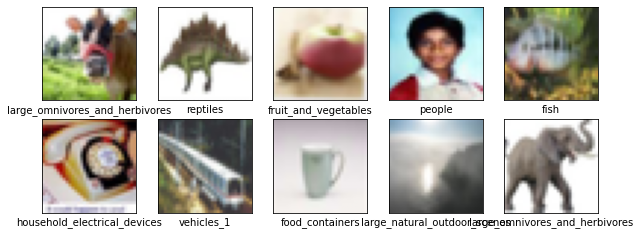

In [13]:

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagesTrain[i])
    plt.xlabel(coarse_labels_train[i])
plt.show()

Визуализация на примерни данни от тестовата партида

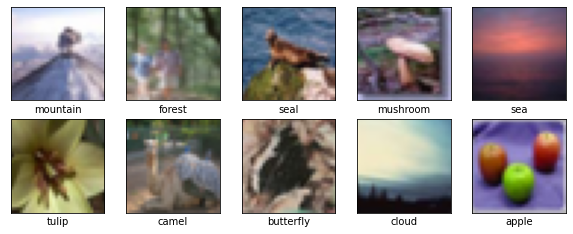

In [8]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagesTest[i])
    plt.xlabel(fine_labels_test[i])
plt.show()

In [12]:
device = "cuda" if torch.cuda.is_available() else   "cpu"
print(device)
torch.cuda.list_gpu_processes()

cuda


'pynvml module not found, please install pynvml'